In [1]:
import pandas as pd
import numpy as np

#modeling
from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from classification_functions import logistic_model, knn_classification, conf_matrix, plot_roc, decision_tree
from classification_functions import random_forest, multinomial_nb

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#set the rc parameters
plt.style.use('ggplot')
plt.rc('font', size=10)

Load data

In [3]:
df = pd.read_pickle('../Data/survey_data_cleaned2.pkl')

### EDA

In [4]:
# # We want to pick one feature to start that separates the two cases.
# sns.pairplot(df[['OpSys', 'Age', 'Age1stCode', 'YearsCode', 'YearsCodePro', 'database_count']], 
#              corner=True, height=1.5, plot_kws={'size': 3}, hue='OpSys')

In [5]:
# categorical_columns = ['database_count', 'EdLevel', 'Ethnicity', 'Gender', 'UndergradMajor', 'Region']
# fig, ax =plt.subplots(3,2, gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=(15,15))
# idx = 0
# for x in range(0,3):
#     for y in range(0,2):
#         sns.countplot(x = categorical_columns[idx], hue='OpSys', data=df, ax=ax[x,y])
#         ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(),rotation=20)
#         idx= idx+1
# fig.show()

In [6]:
# binary_columns = ['Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 'Designer',
#                  'System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work',
#                  'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']
# fig, ax =plt.subplots(7,3, gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, figsize=(15,25))
# idx = 0
# for x in range(0,7):
#     for y in range(0,3):
#         if idx >= 19:
#             break
#         sns.countplot(x = binary_columns[idx], hue='OpSys', data=df, ax=ax[x,y])
#         idx= idx+1
# fig.show()

### Baseline Modeling

In [7]:
X = df[['database_count', 'EdLevel', 'Ethnicity', 'Gender', 'UndergradMajor', 'Region', 
        'Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 
        'Designer','System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work', 
       'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']]
y = df['OpSys']

X=pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
#X.info()

Multinomial NB:

Accuracy: 0.5336,
Precision score: 0.516,
Recall score: 0.47739999999999994,
f1 score: 0.4783999999999999,
fbeta score for beta = 0.1: 0.5147999999999999,
ROC AUC score: 0.6093999999999999,
Log-loss: 16.1092,



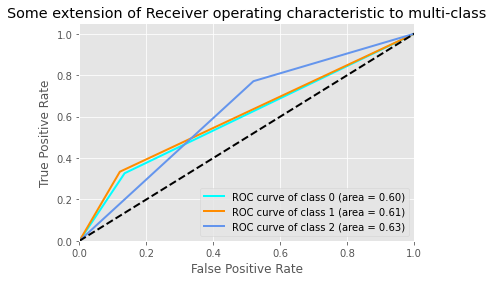

MultinomialNB()

In [8]:
multinomial_nb(X_train, y_train, b = 0.1)

Random Forest with 100 estimators:

Accuracy: 0.767,
Precision score: 0.7624000000000001,
Recall score: 0.7504000000000001,
f1 score: 0.7555999999999999,
fbeta score for beta = 0.1: 0.7624000000000001,
ROC AUC score: 0.8134,
Log-loss: 8.0506,



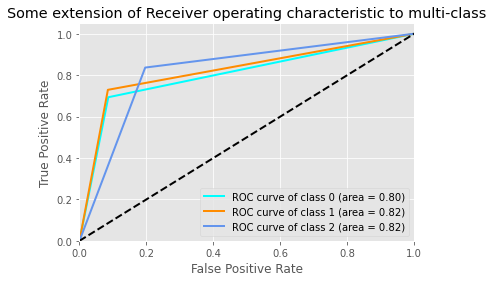

In [9]:
rf = random_forest(X_train, y_train, estimators = 100, b = 0.1)

Decision Tree with max depth of 5:

Accuracy: 0.5192,
Precision score: 0.4986,
Recall score: 0.46460000000000007,
f1 score: 0.4624,
fbeta score for beta = 0.1: 0.4972,
ROC AUC score: 0.5997999999999999,
Log-loss: 16.609,



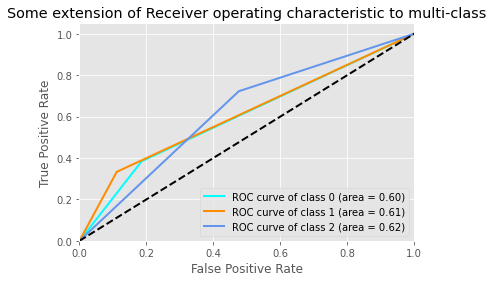

In [10]:
dt = decision_tree(X_train, y_train, depth = 5, b = 0.1)

logistic regression with C = 1:

Accuracy: 0.5494000000000001,
Precision score: 0.5278,
Recall score: 0.5029999999999999,
f1 score: 0.5065999999999999,
fbeta score for beta = 0.1: 0.5274000000000001,
ROC AUC score: 0.6294000000000001,
Log-loss: 15.566399999999998,



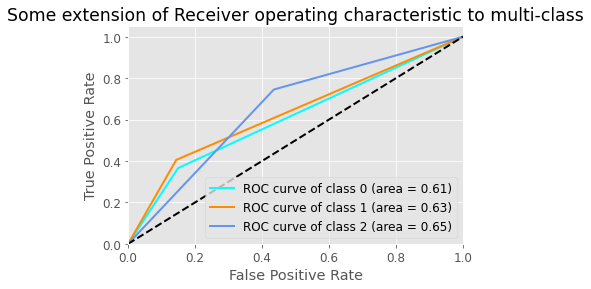

In [11]:
plt.rc('font', size=12)
lm = logistic_model(X_train, y_train, regularization = 1, threshold =  False, threshold_val = 0.5, b = 0.1)
#conf_matrix(lm_mn, X_test, y_test)

In [ ]:
knn = knn_classification(X_train, y_train, k = 5, b = 0.1)
#conf_matrix(knn, X_test, y_test)